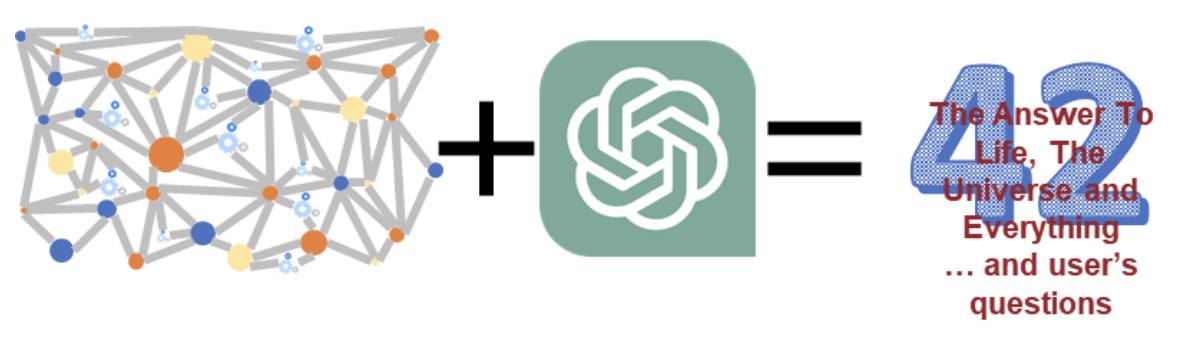

### Prerequisites

This notebook is a demonstration of an OpenAI ChatGPT performance of KGC tasks on the Wikidata5M dataset and its comparison to our custom model.

More details about experiments are on our blog post - [link].

One can find the details and code for the custom model in this notebook - [link](https://drive.google.com/file/d/1VzbTAYrzlPCIFr4TXph6osYGGPLmSSXi/view?usp=sharing).


### Libs

In [ ]:
! pip install -r requirements.txt

In [ ]:
import openai
import time

import pickle
import json

from tqdm.auto import tqdm
import numpy as np

import re
import string

### Setup

Loading OpenAI Api Token.

If you would like to fully test or use our code, you should upload your own OpenAI token in a JSON format ``` {"key": TOKEN} ``` to the same folder with this notebook.

In [ ]:
with open("api_key.json", "r") as f:
    api_key = json.load(f)
openai.api_key = api_key["key"]

Setting up the model's parameters

In [ ]:
params = {
    "max_tokens": 10,
    "temperature": 1.0,
    "top_p": 1,
    "n": 3,
    "stream": False,
    "stop": None,
}

Functions for output normalization and exact match calculation

We need to use output normalization to avoid cases when gpt returns strings with articles, redundant spaces, or punctuation

In [ ]:
def normalize_answer(s):
    def remove_tail(text):
        return text.replace("tail", "")

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split()).strip()

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_tail(remove_articles(remove_punc(lower(s)))))


def exact_match(y_true, y_predicted):
    EM_total = 0
    count = 0

    for ground_truth, prediction in zip(y_true, y_predicted):
        count += 1
        if isinstance(prediction, str):
            prediction = [prediction]

        EMs = [
            int(normalize_answer(ground_truth) == normalize_answer(p))
            for p in prediction
        ]

        # if at least one generated prediction is true, set that model is correct (~hits@len(predicted))
        EM_total += max(EMs)
    return 100 * EM_total / count if count > 0 else 0

### Testing model's output

In [ ]:
system_prompt = (
    "You will be provided with a incomplete triplet from the Wikidata knowledge graph. "
    "Your task is to complete the triplet with a tail (subject) based on the given triplet head (object) and relation. "
    "Your answer should only include the tail of the triplet. "
    "To help you with the task you will be provided with adjacent relations and subjects. Requested subject may not be from provided adjacent subjects."
)


user_text = "Adjacent relations: {}\n" "Triplet to complete: {}. Tail: "

r = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": user_text.format(
                "instance of icebreaker [SEP] instance of research vessel [SEP] has part helicopter deck [SEP] named after polar bear [SEP] owned by GC Rieber Shipping [SEP] owned by Ministry of Defence [SEP] operator Royal Navy [SEP] color white [SEP] color red [SEP] color green [SEP] home port HMNB Devonport [SEP] armament Minigun [SEP] armament FN MAG [SEP]".replace(
                    " [SEP]", ";"
                ),
                "HMS Protector instance of",
            ),
        },
    ],
    **params
)
print(r["choices"][1]["message"]["content"])

We calculate Hits@1 and Hits@3 for gpt-4 model, so we are only interested in first 3 choices made by the gpt model

In [ ]:
print(r["choices"])

### Loading the dataset

We grouped inputs, targets, and our model's prediction from the Wikidata5M dataset in advance for convenience of use.

One can find code for the out model inference in the [notebook](https://drive.google.com/file/d/1VzbTAYrzlPCIFr4TXph6osYGGPLmSSXi/view?usp=sharing).

In [ ]:
! wget  --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nc_yHKw0PWaPGwjuZfzcePP7rcy3rD9e&confirm=####' -O model_predictions.pickle

In [ ]:
wikidata_test = pickle.load(open("model_predictions.pickle", "rb"))

In [ ]:
print("Dataset contains: ", list(wikidata_test.keys()))
print("Length of the dataset: ", len(wikidata_test["input_strings"]))

The format of input, target, and output is consistent with the ones we used in our model

In [ ]:
wikidata_test["input_strings"][2], wikidata_test["target_strings"][2], wikidata_test[
    "prediction_strings"
][2]

### Loading gpt-4 predictions

Running gpt-4 on the entire test dataset can be costly, so we have prepared the predictions from the test so that one can review them and calculate the necessary metrics

In [ ]:
! wget  --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p3421eukbo4dvHRMqZtotnBuzV3Cz8_x&confirm=####' -O 'wikidata_test_gpt-4_without_neighbors.pckl'
! wget  --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Ot7K03ymJYsZGFdTEkbTWoVmBKpeUsvm&confirm=####' -O 'wikidata_test_gpt-4-with_neighbors.pckl'

### Model's predictions without neighborhood in the context

In [ ]:
# collect predictions without neighborhood
usage_stats = {"prompt_tokens": 0, "completion_tokens": 0, "total_tokens": 0}
predictions = {}

system_prompt = (
    "You will be provided with an incomplete triplet from the Wikidata knowledge graph. "
    "Your task is to complete the triplet with a tail (subject) based on the given triplet head (object) and relation. "
    "Your answer should only include the tail of the triplet."
)

for i in tqdm(range(len(wikidata_test["input_strings"]))):
    query = (
        " ".join(wikidata_test["input_strings"][i].split(" [SEP] ")[1:2])
        .replace("[SEP]", "")
        .strip()
    )
    user_text = f"{query}. Tail: "

    while True:
        try:
            r = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_text},
                ],
                **params,
            )
            time.sleep(0.1)
            break
        except (openai.error.RateLimitError, openai.error.ServiceUnavailableError) as e:
            print(i, e)
            time.sleep(5)

    predictions[i] = [c["message"]["content"] for c in r["choices"]]
    for k in r["usage"]:
        usage_stats[k] += r["usage"][k]

In [ ]:
pickle.dump(predictions, open("wikidata_test_gpt-4_without_neighbors.pckl", "wb"))

In [ ]:
predictions = pickle.load(open("wikidata_test_gpt-4_without_neighbors.pckl", "rb"))

Calculating the metrics

In [ ]:
# chatgpt predictions EM, hits@3
exact_match(
    [wikidata_test["target_strings"][i] for i in predictions.keys()],
    [predictions[i] for i in predictions.keys()],
)

In [ ]:
# chatgpt predictions EM, hits@1
exact_match(
    [wikidata_test["target_strings"][i] for i in predictions.keys()],
    [predictions[i][0] for i in predictions.keys()],
)

### Model's prediction without neighborhood in the context

In [ ]:
# collect predictions without neighborhood
usage_stats = {"prompt_tokens": 0, "completion_tokens": 0, "total_tokens": 0}
predictions_with_neighbors = {}

system_prompt = (
    "You will be provided with an incomplete triplet from the Wikidata knowledge graph. "
    "Your task is to complete the triplet with a tail (subject) based on the given triplet head (object) and relation. "
    "Your answer should only include the tail of the triplet. "
    "To help you with the task you will be provided with adjacent relations and subjects. Requested subject may not be from provided adjacent subjects."
)

limit_count = 0

for i in tqdm(range(len(wikidata_test["input_strings"]))):
    query = (
        " ".join(wikidata_test["input_strings"][i].split(" [SEP] ")[1:2])
        .replace("[SEP]", "")
        .strip()
    )
    neigh = "; ".join(wikidata_test["input_strings"][i].split(" [SEP] ")[2:]).replace(
        " [SEP]", ";"
    )
    user_text = f"Adjacent relations: {neigh}\nTriplet to complete: {query}. Tail: "

    while True:
        try:
            r = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_text},
                ],
                **params,
            )
            time.sleep(0.5)
            break
        except (openai.error.RateLimitError, openai.error.ServiceUnavailableError) as e:
            limit_count += 1
            if limit_count % 100 == 0:
                print(e)
            time.sleep(5)

    predictions_with_neighbors[i] = [c["message"]["content"] for c in r["choices"]]
    for k in r["usage"]:
        usage_stats[k] += r["usage"][k]

In [ ]:
pickle.dump(
    predictions_with_neighbors, open("wikidata_test_gpt-4-with_neighbors.pckl", "wb")
)

In [ ]:
predictions_with_neighbors = pickle.load(
    open("wikidata_test_gpt-4-with_neighbors.pckl", "rb")
)

In [ ]:
# our model's predictions EM, hits@1
exact_match(
    [wikidata_test["target_strings"][i] for i in predictions.keys()],
    [wikidata_test["prediction_strings"][i] for i in predictions.keys()],
)

In [ ]:
# chatgpt predictions EM, hits@3
exact_match(
    [wikidata_test["target_strings"][i] for i in predictions_with_neighbors.keys()],
    [predictions_with_neighbors[i] for i in predictions_with_neighbors.keys()],
)

In [ ]:
# chatgpt predictions EM, hits@1
exact_match(
    [wikidata_test["target_strings"][i] for i in predictions_with_neighbors.keys()],
    [[predictions_with_neighbors[i][0]] for i in predictions_with_neighbors.keys()],
)

### Conclusions

As the experiments in the notebook demonstrated, our model still works better on KGC task than OpenAI ChatGPT-4.

However, providing neighbors of the query head extracted from Wikidata to the gpt-4 context improves its quality.